# Pixel drill using interactive widgets

**What does this notebook do?** This notebook demonstrates how to perform a pixel drill using an interactive widget. A plot is drawn up of a single time slice for Canberra so the user can select a pixel to interrogate further. Once a pixel is selected, a timeseries is plotted up for that pixel, using the green band as an example. Users can then select a point in the time series plot to generate a plot showing the corresponding satellite image for that point in time.

**Date** May 2018

**Author** Claire Krause

In [1]:
%pylab notebook

from datacube import Datacube
import pandas as pd

# Import widgets for interactive notebook
from ipywidgets import interact, fixed
import ipywidgets as widgets

# Import the custom script for plotting. This script can be found in the dea-notebooks repository.
import sys
import os
sys.path.append(os.path.abspath('/g/data/r78/cek156/dea-notebooks/Scripts'))
import DEAPlotting

dc = Datacube(app='pixel_drill')

Populating the interactive namespace from numpy and matplotlib


## Set up the extraction query

In [2]:
query = {'lat': (-35.25, -35.35),
         'lon': (149.05, 149.17)
         }

## First, pull in the data from Landsat 8

Note that for simplicity, the data have not been cloud filtered in this example.

In [3]:
data = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query)

In [4]:
data

<xarray.Dataset>
Dimensions:          (time: 221, x: 492, y: 500)
Coordinates:
  * time             (time) datetime64[ns] 2013-04-18T23:52:06 ...
  * y                (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x                (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) int16 215 217 419 468 493 511 398 379 350 ...
    blue             (time, y, x) int16 174 182 410 440 496 519 385 398 354 ...
    green            (time, y, x) int16 287 296 573 683 711 669 600 575 590 ...
    red              (time, y, x) int16 302 293 541 661 694 707 592 590 587 ...
    nir              (time, y, x) int16 966 930 1387 1643 1638 1579 1719 ...
    swir1            (time, y, x) int16 662 637 1021 1255 1244 1151 1261 ...
    swir2            (time, y, x) int16 394 389 739 882 869 836 768 852 854 ...
Attributes:
    crs:      EPSG:3577

## Plot up an image so we can select a pixel for further interrogation

This example uses a function called `three_band_image`. This function is available within the `DEAPlotting.py` file in the `Scripts` folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/Scripts).

<IPython.core.display.Javascript object>


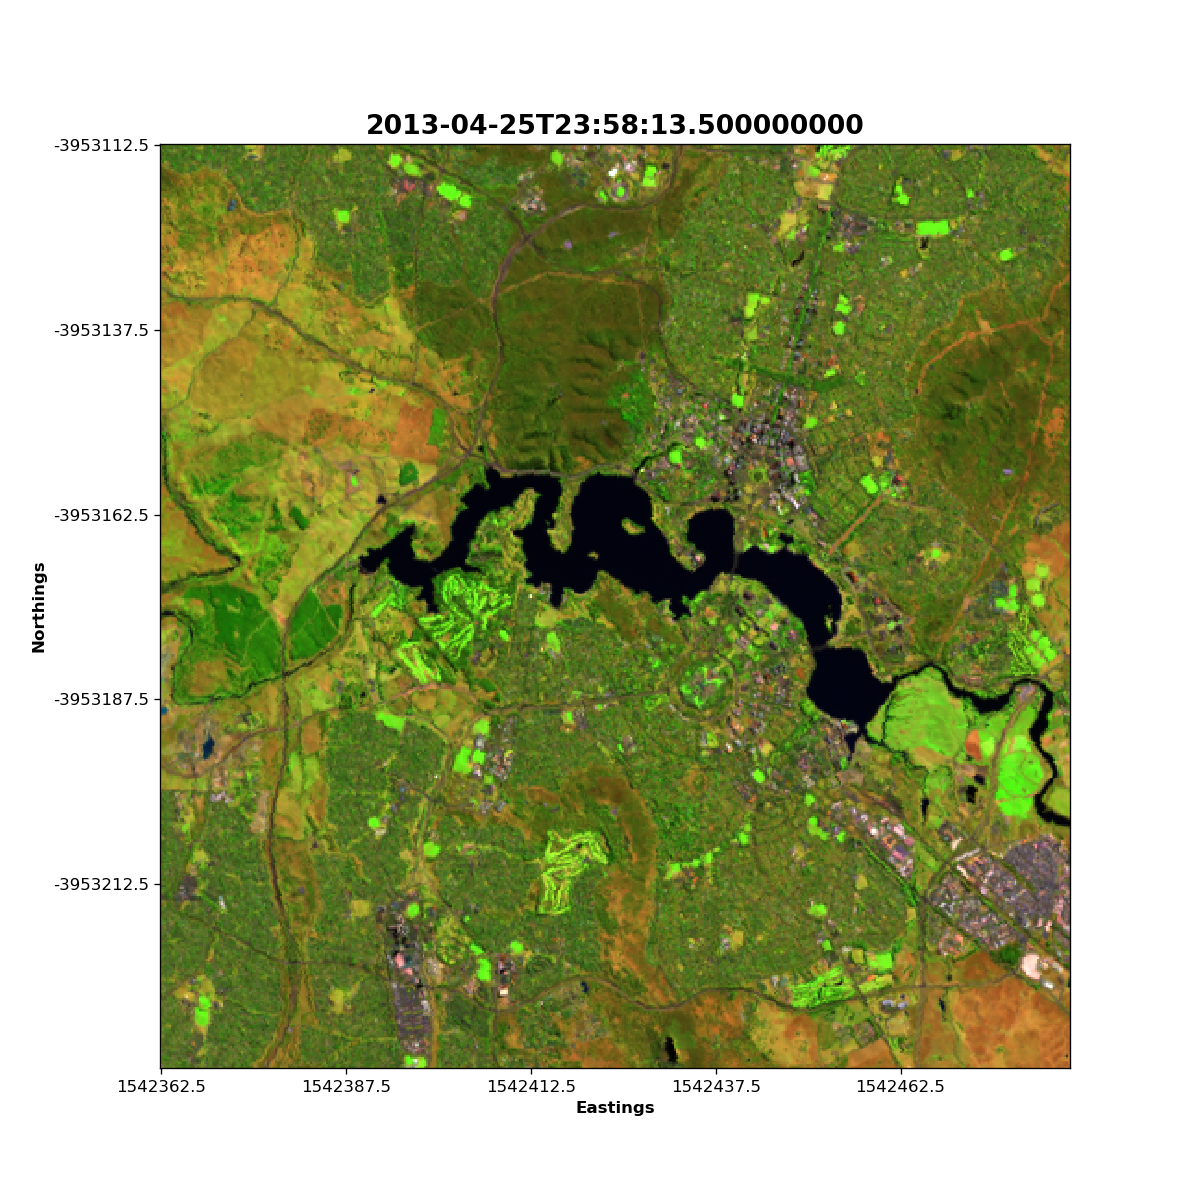

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


HTML(value='Click on the pixel you would like to interrogate')

In [5]:
DEAPlotting.three_band_image(data, bands=['swir1', 'nir', 'green'], time=1)

fig = plt.gcf()
w = widgets.HTML("Click on the pixel you would like to interrogate")


def onclick(event):
    global pixelx, pixely
    x, y = int(event.xdata), int(event.ydata)
    image_coords = data.affine * (x, y)
    pixelx = int(image_coords[0])
    pixely = int(image_coords[1])
    w.value = 'pixelx : {}, pixely : {}'.format(pixelx, pixely)


cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

## Plot up the complete timeseries of data for a single pixel

For the sake of this demonstration, we just choose to plot up the `green` spectral band. This workflow would also work for an index, like NDVI.

<IPython.core.display.Javascript object>


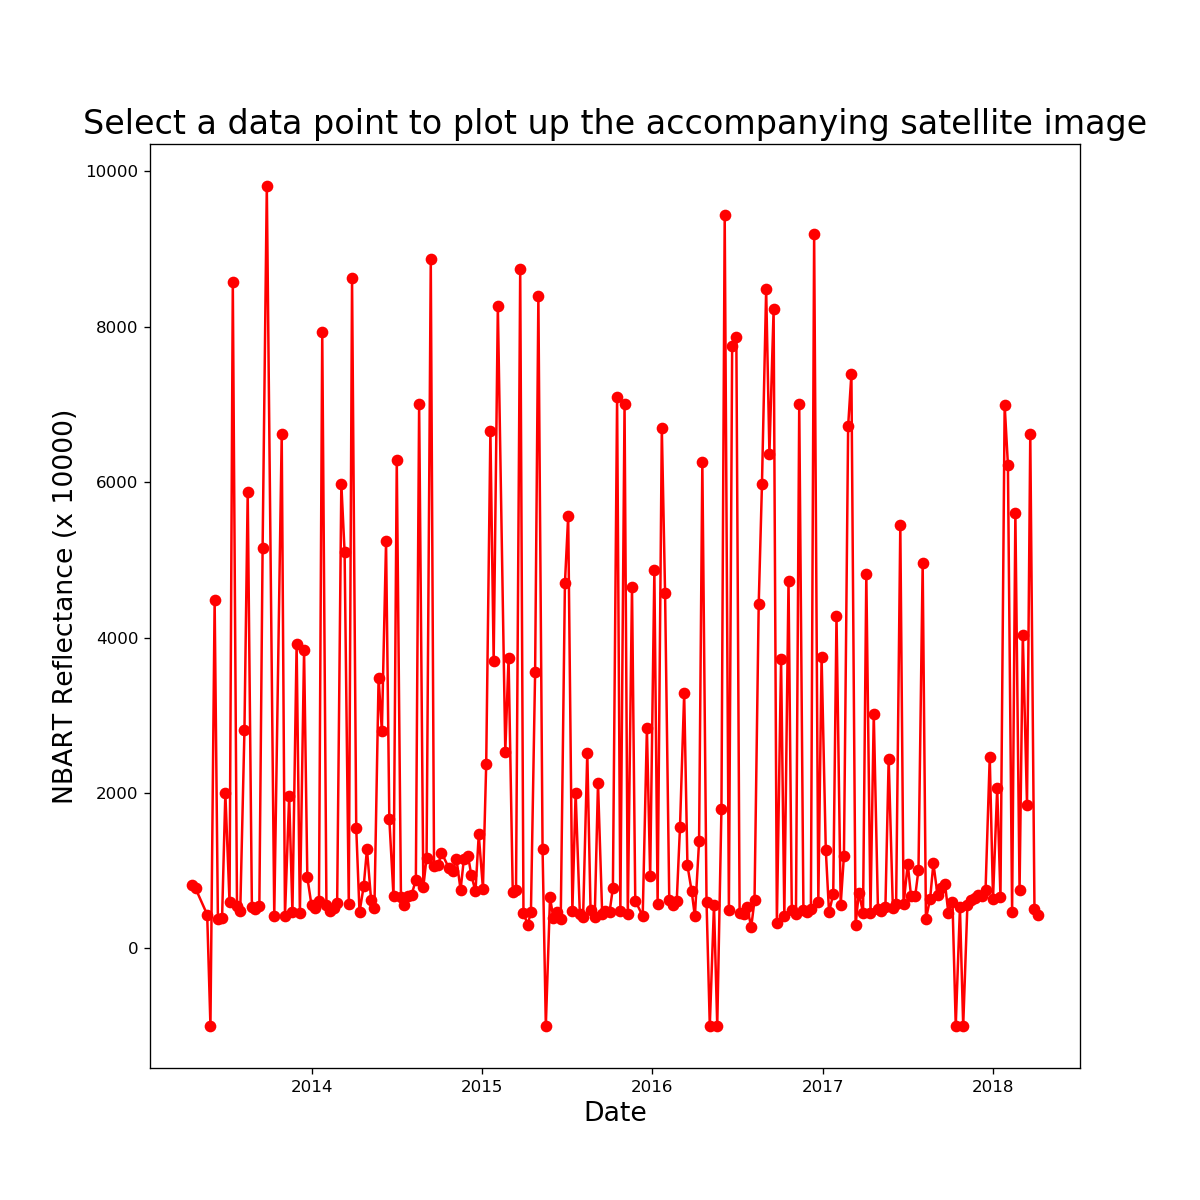

HTML(value='Click on the time you would like to display')

In [6]:
fig = plt.figure(figsize=[10, 10])

plt.plot(data.time, data.green.sel(
    y=pixely, x=pixelx, method='nearest'), 'ro-')
plt.xlabel('Date', fontsize=16)
plt.ylabel('NBART Reflectance (x 10000)', fontsize=16)
plt.title(
    'Select a data point to plot up the accompanying satellite image', fontsize=20)

w = widgets.HTML("Click on the time you would like to display")


def onclick(event):
    global timeOfInterest
    timeOfInterest = event.xdata
    w.value = 'time of interest : {}'.format(timeOfInterest)


cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

<div class="alert alert-info">

**Note:** In this example, we have not filtered out clouds. You can see in the above plot that there are a lot of values clustered around ~1000, then values up to ~10,000. If you click through these pixels, you will notice that these higher values are actually images where the scene is cloudy. The collection of values ~1000 represent the scenes where the sensor had a clear image of the pixel chosen, and so represent actual ground green band values. If we had filtered out the cloud impacted scenes, the values > ~1000 would be removed, as would the values below zero, which represent missing values for the chosen pixel.

</div>

### Convert the selected time to a time stamp we can use to extract the correct scene

In [9]:
# Convert clicked int to datetime format
time_slice = matplotlib.dates.num2date(timeOfInterest).date()
# Convert clicked value to str
time_slice = str(time_slice)
# Convert clicked value to correct datetime format
time_slice = pd.to_datetime(time_slice, format='%Y-%m-%d')
time_slice

Timestamp('2017-10-01 00:00:00')

## Plot the scene that matches the selected time and sensor

<IPython.core.display.Javascript object>


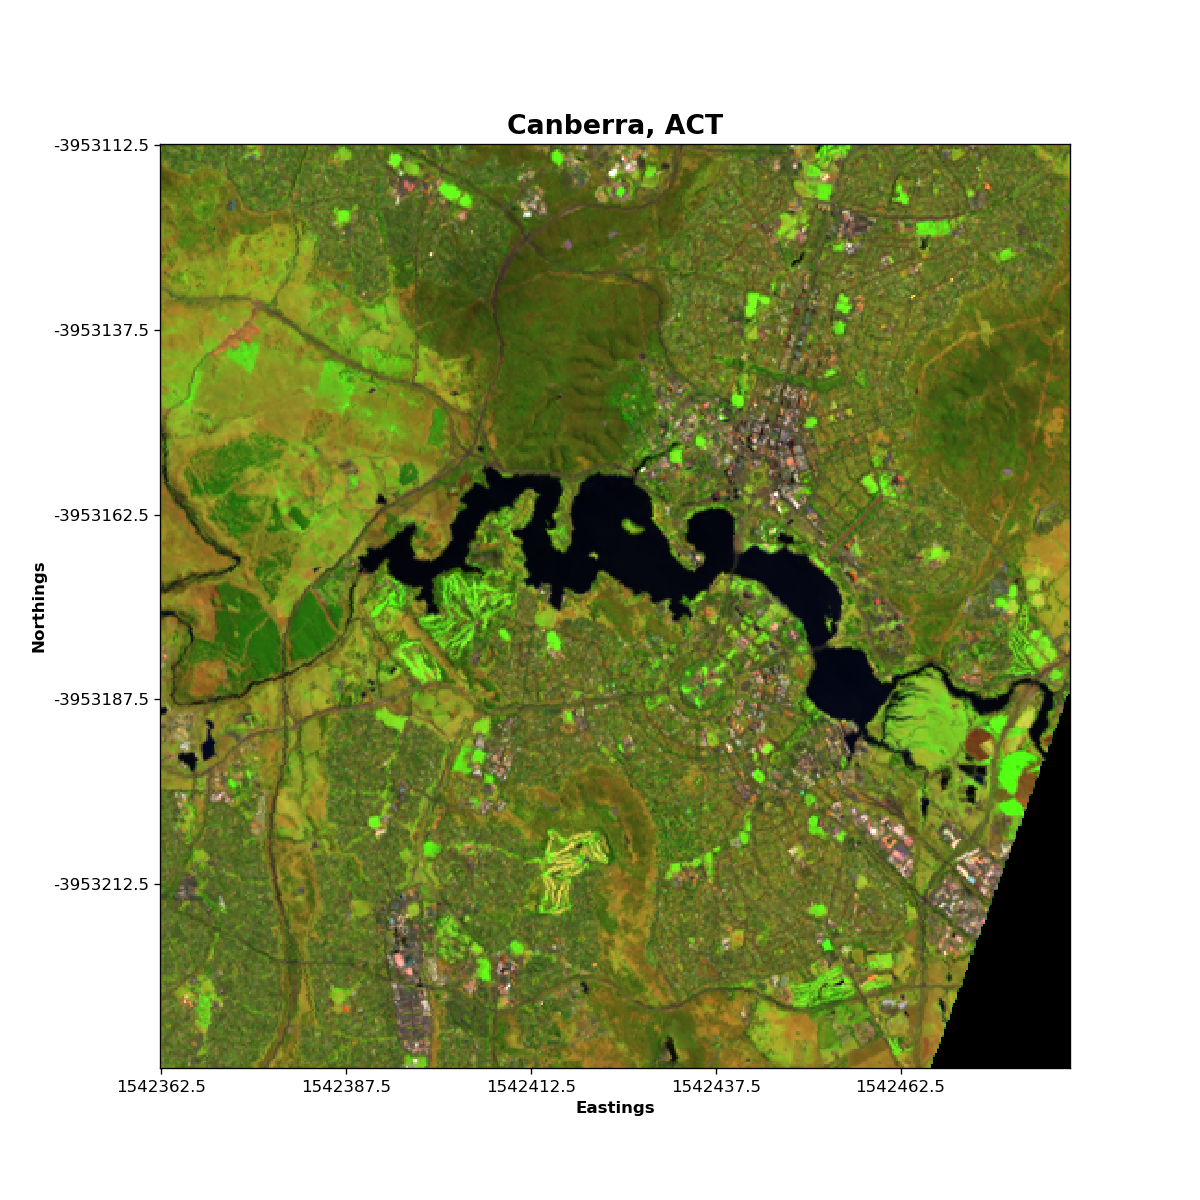

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [10]:
DEAPlotting.three_band_image(data.sel(time=time_slice, method='nearest'), bands=['swir1', 'nir', 'green'],
                             title='Canberra, ACT')